In [1]:
import psycopg2
from sqlalchemy import create_engine, Column, Integer, String, Float, ForeignKey
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import relationship, sessionmaker
import re
from __future__ import print_function

In [2]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
import pandas as pd
from nltk.stem.snowball import SnowballStemmer
import tensorflow as tf

In [3]:
dbname = 'restaurants'
username = 'andylane'
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)
con = None
con = psycopg2.connect(database = "restaurants", user = "andylane")
Session = sessionmaker(bind=engine)
session = Session()

postgres://andylane@localhost/restaurants


/home/andylane/anaconda2/envs/insight/lib/python2.7/site-packages/sqlalchemy/dialects/__init__.py:34: SADeprecationWarning: The SQLAlchemy PostgreSQL dialect has been renamed from 'postgres' to 'postgresql'. The new URL format is postgresql[+driver]://<user>:<pass>@<host>/<dbname>
  module = __import__('sqlalchemy.dialects.%s' % (dialect, )).dialects


In [4]:
from menusights_aux import *

In [5]:
recipes = pd.read_sql("recipes", engine)

## Get recipe names into a vector

In [6]:
stopwords = nltk.corpus.stopwords.words('english')
stemmer = SnowballStemmer("english")

## Match menu items to a cluster

In [7]:
recipes.head()

/home/andylane/anaconda2/envs/insight/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/home/andylane/anaconda2/envs/insight/lib/python2.7/site-packages/IPython/core/formatters.py:98: DeprecationWarning: DisplayFormatter._formatters_default is deprecated: use @default decorator instead.
  def _formatters_default(self):
/home/andylane/anaconda2/envs/insight/lib/python2.7/site-packages/IPython/core/formatters.py:677: DeprecationWarning: PlainTextFormatter._deferred_printers_default is deprecated: use @default decorator instead.
  def _deferred_printers_default(self):
/home/andylane/anaconda2/envs/insight/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self)

,id,name,url,calories,fat,carbs,protein,cholesterol,sodium,servings
0,1,Fluffy Pancakes,http://allrecipes.com/recipe/162760/fluffy-pan...,230,8.2,32.7,6.4,65.0,650.0,4
1,2,Joan's Quick Chili,http://allrecipes.com/recipe/240622/joans-quic...,397,21.5,25.2,26.7,71.0,1438.0,4
2,3,Ultimate Double Chocolate Cookies,http://allrecipes.com/recipe/15097/ultimate-do...,148,6.8,21.4,2.2,25.0,88.0,42
3,4,Campfire Banana Splits,http://allrecipes.com/recipe/20038/campfire-ba...,545,17.3,106.2,4.7,0.0,47.0,6
4,5,Pumpkin Chocolate Chip Cookies II,http://allrecipes.com/recipe/10117/pumpkin-cho...,224,11.5,29.5,2.8,10.0,127.0,18


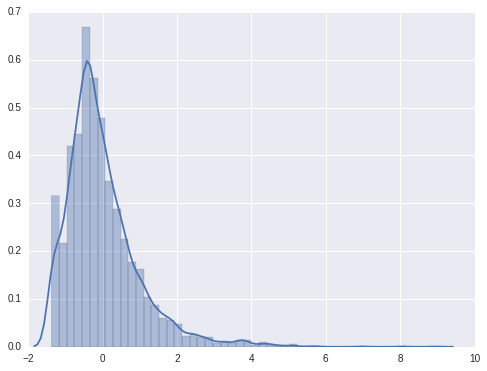

In [10]:
# Plot distribution of cholesterol etc; looks like it's normalish
from sklearn.preprocessing import scale
def normalize(item):
    a = scale(recipes[item], axis=0, with_mean=True, with_std=True, copy=True )
    return a

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
ax = sns.distplot(normalize("cholesterol"), label="chol")
#ax = sns.distplot(normalize("calories"))
#ax = sns.distplot(normalize("protein"))

In [9]:
def tokenize_and_stem(title):
    stemmer = SnowballStemmer("english")
    stemmed_titles = []
    new_title=[]
    for word in nltk.word_tokenize(title):
        new_title.append(stemmer.stem(word))
    stemmed_titles.extend(new_title)
    return " ".join([i for i in stemmed_titles])

In [11]:
tokenized_names = [tokenize_and_stem(i) for i in (recipes["name"])]

In [ ]:
tokenized_names[99]

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

In [13]:
vectorizer = CountVectorizer(ngram_range=(1,3), min_df=0.0003)

In [14]:
a = vectorizer.fit_transform(tokenized_names)

In [15]:
len(vectorizer.get_feature_names())

3453

In [16]:
a

<3941x3453 sparse matrix of type '<type 'numpy.int64'>'
	with 28567 stored elements in Compressed Sparse Row format>

In [17]:
vectorizer.vocabulary_.get('minc')

1969

In [18]:
vectorizer.get_feature_names()[2256]

u'pie'

In [19]:
sum(a.toarray()[:,2701])

208

In [20]:
from sklearn.feature_selection import f_regression, mutual_info_regression

In [21]:
# produces an array with mutual information (weights?) between individual words/n-grams in recipe names and cholesterol information
mi = mutual_info_regression(a, recipes["cholesterol"])
mi /= np.max(mi)

In [22]:
#[(index, i, vectorizer.get_feature_names()[index]) for index, i in enumerate(mi) if i>0.01]

[(0, 0.019422527770953772, u'acorn'),
 (1, 0.019422527770953772, u'acorn squash'),
 (7, 0.014865655586902169, u'aioli'),
 (9, 0.063034048743356955, u'al tonno'),
 (13, 0.031591162213226893, u'alfredo'),
 (14, 0.021684946062962202, u'alfredo pasta'),
 (20, 0.013627996718424792, u'almond'),
 (22, 0.021555947352981324, u'almond chicken'),
 (27, 0.024726302234324621, u'amaz pork tenderloin'),
 (29, 0.010263549431077651, u'amish'),
 (31, 0.011775715953625719, u'and almond'),
 (47, 0.014508829315116201, u'and blue'),
 (52, 0.048755366732576119, u'and broccoli'),
 (53, 0.010592645885868316, u'and broccoli pasta'),
 (60, 0.01019832932473704, u'and cauliflow'),
 (66, 0.027352795760279536, u'and chicken'),
 (71, 0.016403846667356618, u'and coconut'),
 (82, 0.046196069171825553, u'and dumpl'),
 (84, 0.014690149176446758, u'and easi chicken'),
 (86, 0.043798907735924424, u'and egg'),
 (87, 0.050664443878828014, u'and egg salad'),
 (88, 0.014087938507014583, u'and fast'),
 (93, 0.035936163465733528

In [120]:
# Returns indices of columns with MI value greater than e.g. 0.01. Can be used for re
informative_words = np.array([(index) for index, i in enumerate(mi) if i>0.02])
# return word vector array with uninformative words removeds
culled_array = a.toarray()[:,informative_words]

In [121]:
culled_array.shape

(3941, 437)

In [122]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

from sklearn import datasets, linear_model


X_train = culled_array
y_train = recipes["cholesterol"]

X_test = a[:200]
y_test = recipes["cholesterol"][:200]

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [123]:
# Try fitting an elasticnet model!
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
enet = ElasticNet()
enetmodel=enet.fit(culled_array[200:], y_train[200:])
y_predicted = enetmodel.predict(culled_array[:200])
# Evaluate by comparing predicted cholesterol to actual cholesterol
r2_score_enet = r2_score(y_test, y_predicted)
r2_score_enet #oh no it's -0.29...

-0.2873515585094828

In [124]:
import cPickle as pkl

In [147]:
ground_truth_x =[]
ground_truth_y =[]
for item in pkl.load(open("groundtruth.pkl", "rb")):
    ground_truth_x.append(item["item_name"])
    ground_truth_y.append(item["nf_cholesterol"])

In [148]:
for item in pkl.load(open("groundtruth2.pkl", "rb")):
        ground_truth_x.append(item["item_name"])
        ground_truth_y.append(item["nf_cholesterol"])

In [149]:
for item in pkl.load(open("groundtruth3.pkl", "rb")):
        ground_truth_x.append(item["item_name"])
        ground_truth_y.append(item["nf_cholesterol"])


In [128]:
tokenized_names_ground_truth = [tokenize_and_stem(i) for i in (ground_truth_x)]

In [129]:
# Puts words from new ground truth set into matrix from training set
ground_truth_vectorized = vectorizer.transform(tokenized_names_ground_truth)

In [130]:
ground_truth_vectorized_culled_array = ground_truth_vectorized.toarray()[:,informative_words]
y_predicted = enetmodel.predict(ground_truth_vectorized_culled_array)
r2_score_enet = r2_score(ground_truth_y, y_predicted)
r2_score_enet #oh no it's still bad...

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

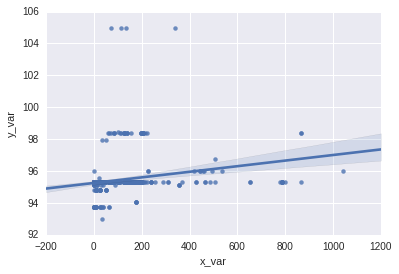

In [131]:
x,y = pd.Series(ground_truth_y, name="x_var"), pd.Series(y_predicted, name="y_var")
ax = sns.regplot(x=x, y=y)

## So, the elasticnet model (a linear regression) has poor predictive power at default parameters. Can we optimize the parameters?

In [132]:
%matplotlib inline
# Compute paths
from sklearn.linear_model import ElasticNetCV
import time, copy
from sklearn.metrics import r2_score

def enetcv(culled_array, y_train, ground_truth_vectorized_culled_array, ground_truth_y):
    #culledarrayecv = np.sqrt(np.sum(culledarrayecv ** 2, axis=0)) / culledarrayecv
    model = ElasticNetCV(cv=100).fit(culled_array, y_train)
    m_log_alphas = -np.log10(model.alphas_)
    y_predicted_cv = model.predict(ground_truth_vectorized_culled_array)
    x,y = pd.Series(ground_truth_y, name="actual cholesterol"), pd.Series(y_predicted_cv, name="predicted cholesterol")
    ax = sns.regplot(x=x, y=y)
    for index, i in enumerate(ground_truth_y):
        if i == None:
            ground_truth_y[index] = 0
    return (r2_score(ground_truth_y, y_predicted_cv), model)

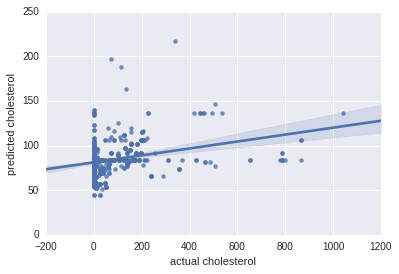

In [66]:
# with 3 ground truth datasets
r2, model = enetcv(culled_array, y_train, ground_truth_vectorized_culled_array, ground_truth_y)

In [67]:
y_predicted_cv = model.predict(ground_truth_vectorized_culled_array)

0.070509135242602161

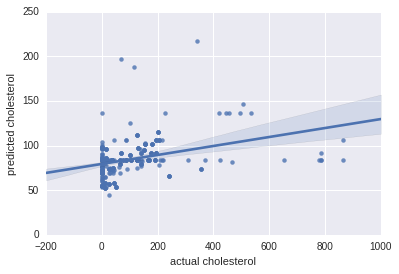

In [56]:
# With two groundtruth datasets
enetcv(culled_array, y_train, ground_truth_vectorized_culled_array, ground_truth_y)

In [58]:
culled_array.shape

(3941, 905)

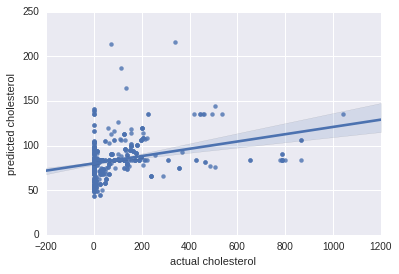

In [87]:
# with 0.002 mi cutoff
r2, model = enetcv(culled_array, y_train, ground_truth_vectorized_culled_array, ground_truth_y)

In [90]:
print(r2) # This is worse. Try higher MI?

0.0609889041977


0.0607199926474


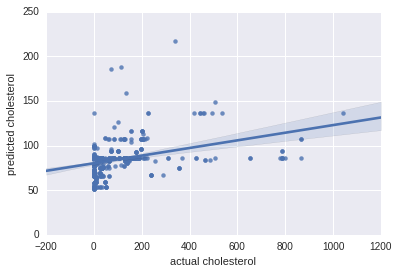

In [133]:
# with 0.02 mi cutoff
r2, model = enetcv(culled_array, y_train, ground_truth_vectorized_culled_array, ground_truth_y)
print(r2)

0.0573923428152


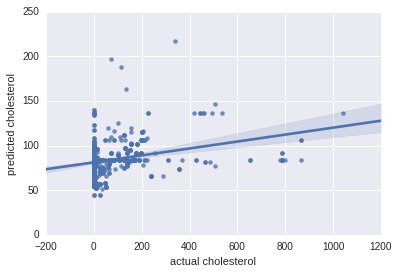

In [119]:
# back to 0.01 mi cutoff
r2, model = enetcv(culled_array, y_train, ground_truth_vectorized_culled_array, ground_truth_y)
print(r2)

## woohoo with an optimized elasticnet model, there's a 0.13705 Rsq

### How about turning it into a classification model? use 0.02 mi cutoff

In [174]:
model.coef_

array([ -3.72679529e+00,   1.83580911e+01,   4.87620592e+00,
        -3.14288520e+00,  -4.08988008e-01,  -1.20243788e+01,
        -1.49155624e+01,  -3.77439805e+00,   2.30310193e+01,
         9.85447450e+00,  -8.47012960e+00,   3.15219905e+00,
         4.53514344e+00,  -2.45149887e+00,   2.51072911e-01,
        -1.34004035e+01,  -3.63322894e+00,  -0.00000000e+00,
        -7.41681704e+00,  -1.98786665e+00,  -1.98786690e+00,
        -2.05694396e+00,  -1.69579009e+00,  -1.82829600e+01,
        -2.13223833e+00,  -2.71904377e+00,  -4.48748063e+00,
         1.33465148e+01,  -2.43338806e+00,  -2.43338739e+00,
         8.62883934e+00,   8.04499896e+00,  -5.53867827e-01,
        -2.25203726e-01,  -1.06310459e+01,   0.00000000e+00,
         3.45625005e+00,  -2.40961548e+00,  -1.42883902e+01,
        -1.58936917e-01,   6.55741127e+00,   6.55741336e+00,
        -8.61437725e-01,  -2.24628901e+00,   6.02730437e+00,
        -2.01508636e+00,   2.03902832e+00,  -1.83842077e+01,
        -9.00760749e-01,

In [135]:
len(ground_truth_y)

595

In [136]:
len(y_predicted_cv)

595

In [176]:
remove_unknowns = zip(ground_truth_y, y_predicted_cv)

In [179]:
remove_unknowns = [i for i in remove_unknowns if int(i[1]) !=86]

In [182]:
y_pred_nounk = [a[1] for a in remove_unknowns]
y_truth_nounk = [a[0] for a in remove_unknowns]

In [262]:
def chol_to_percentile(vector):
    pctvector = []
    pct75 = np.percentile(vector, 75)
    pct50 = np.percentile(vector, 50)
    pct10 = np.percentile(vector, 10)
    for index, i in enumerate(vector):
        if i > pct75:
            pctvector.append(4)
        elif i > pct50:
            pctvector.append(3)
        elif i > pct10:
            pctvector.append(2)
        else:
            pctvector.append(1)
    return pctvector

In [263]:
def chol_to_class_predicted(vector):
    pctvector = []
    for index, i in enumerate(vector):
        if i > 110:
            pctvector.append(4)
        elif i > 90:
            pctvector.append(3)
        elif i > 70:
            pctvector.append(2)
        else:
            pctvector.append(1)
    return pctvector

In [264]:
from numpy import percentile
def chol_to_class_known(vector):
    pctvector = []
    for index, i in enumerate(vector):
        if i > 125:
            pctvector.append(4)
        elif i > 40:
            pctvector.append(3)
        elif i > 2:
            pctvector.append(2)
        else:
            pctvector.append(1)
    return pctvector

In [265]:
y_predicted_cv = model.predict(ground_truth_vectorized_culled_array)

In [266]:
for index, i in enumerate(ground_truth_y):
    if i == None:
        ground_truth_y[index] = 0

In [267]:
zip(ground_truth_y, chol_to_percentile(ground_truth_y), chol_to_percentile(y_predicted_cv), y_predicted_cv, ground_truth_x)

[(125, 4, 2, 86.096891605210942, u'Outback Sirloin, 9 Oz'),
 (85, 3, 2, 86.096891605210942, u'Outback Sirloin, 6 Oz'),
 (150, 4, 2, 86.096891605210942, u'Outback Flat Iron'),
 (35, 3, 2, 86.096891605210942, u'Outback Calzone'),
 (170, 4, 2, 86.096891605210942, u'Outback Sirloin, 12 Oz'),
 (25, 3, 2, 74.862728483267588, u'Outback Pizza, Personal'),
 (35, 3, 2, 74.862728483267588, u'Outback Pizza, Medium'),
 (30, 3, 2, 74.862728483267588, u'Outback Pizza, Large'),
 (0, 1, 1, 54.905688459079286, u'Cookies, Kids Outback Animals Chocolate'),
 (10, 3, 1, 59.410972820921756, u'House Salad'),
 (45, 3, 1, 59.410972820921756, u'Sesame Salad'),
 (35, 3, 2, 74.862728483267588, u'Outback Pizza, Family'),
 (130, 4, 2, 83.048877085379033, u'The Outbacker Burger Without Cheese'),
 (130, 4, 2, 86.096891605210942, u"Bloomin' Onion"),
 (70, 3, 4, 93.891294930664316, u'Firecracker Salmon'),
 (175, 4, 4, 92.223699450545496, u'Pork Porterhouse'),
 (0,
  1,
  2,
  65.89269841859803,
  u'Vegetable Pasta Shape

In [183]:
zip(y_truth_nounk, chol_to_percentile(y_truth_nounk), chol_to_percentile(y_pred_nounk), y_pred_nounk)

[(25, 3, 2, 74.862728483267588),
 (35, 3, 2, 74.862728483267588),
 (30, 3, 2, 74.862728483267588),
 (0, 1, 1, 54.905688459079286),
 (10, 2, 2, 59.410972820921756),
 (45, 3, 2, 59.410972820921756),
 (35, 3, 2, 74.862728483267588),
 (130, 4, 3, 83.048877085379033),
 (70, 3, 3, 93.891294930664316),
 (175, 4, 3, 92.223699450545496),
 (0, 1, 2, 65.89269841859803),
 (0, 1, 4, 99.542977349170997),
 (5, 2, 2, 59.410972820921756),
 (10, 2, 2, 64.789312979761405),
 (40, 3, 2, 76.370084224910045),
 (125, 4, 4, 107.05367022834105),
 (0, 1, 2, 72.641773841995814),
 (65, 3, 3, 83.048877085379033),
 (240, 4, 2, 67.352721323925039),
 (205, 4, 4, 107.05367022834105),
 (100, 3, 3, 93.380321174377343),
 (50, 3, 1, 53.918497409362303),
 (195, 4, 4, 107.05367022834105),
 (15, 2, 3, 83.048877085379033),
 (195, 4, 4, 96.24156071035388),
 (25, 3, 2, 68.791363825641852),
 (140, 4, 3, 83.048877085379033),
 (200, 4, 4, 116.53806909889619),
 (140, 4, 3, 83.048877085379033),
 (355, 4, 2, 74.535495037209614),
 (0, 

In [275]:
np.median(y_truth_nounk)

15.0

In [276]:
np.median(y_pred_nounk)

77.246452445949359

In [268]:
zip(y_truth_nounk, chol_to_class_known(y_truth_nounk), chol_to_class_predicted(y_pred_nounk), y_pred_nounk)

[(25, 2, 2, 74.862728483267588),
 (35, 2, 2, 74.862728483267588),
 (30, 2, 2, 74.862728483267588),
 (0, 1, 1, 54.905688459079286),
 (10, 2, 1, 59.410972820921756),
 (45, 3, 1, 59.410972820921756),
 (35, 2, 2, 74.862728483267588),
 (130, 4, 2, 83.048877085379033),
 (70, 3, 3, 93.891294930664316),
 (175, 4, 3, 92.223699450545496),
 (0, 1, 1, 65.89269841859803),
 (0, 1, 3, 99.542977349170997),
 (5, 2, 1, 59.410972820921756),
 (10, 2, 1, 64.789312979761405),
 (40, 2, 2, 76.370084224910045),
 (125, 3, 3, 107.05367022834105),
 (0, 1, 2, 72.641773841995814),
 (65, 3, 2, 83.048877085379033),
 (240, 4, 1, 67.352721323925039),
 (205, 4, 3, 107.05367022834105),
 (100, 3, 3, 93.380321174377343),
 (50, 3, 1, 53.918497409362303),
 (195, 4, 3, 107.05367022834105),
 (15, 2, 2, 83.048877085379033),
 (195, 4, 3, 96.24156071035388),
 (25, 2, 1, 68.791363825641852),
 (140, 4, 2, 83.048877085379033),
 (200, 4, 4, 116.53806909889619),
 (140, 4, 2, 83.048877085379033),
 (355, 4, 2, 74.535495037209614),
 (0, 

/home/andylane/anaconda2/envs/insight/lib/python2.7/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/home/andylane/anaconda2/envs/insight/lib/python2.7/site-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


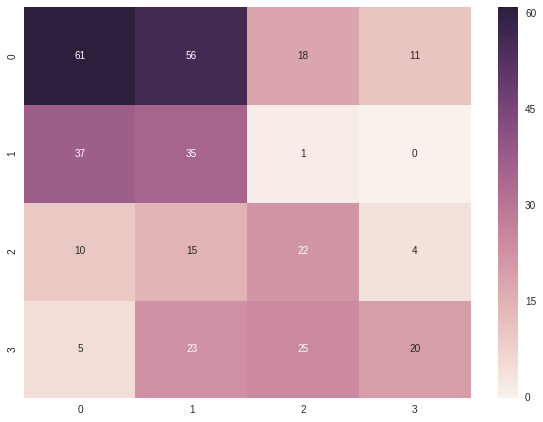

In [271]:
from sklearn.metrics import confusion_matrix
y_true = chol_to_class_known(y_truth_nounk)
y_pred = chol_to_class_predicted(y_pred_nounk)
confusion_matrix(y_true, y_pred)

plt.figure(figsize = (10,7))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)

In [264]:
from numpy import percentile
def chol_to_class_known(vector):
    pctvector = []
    for index, i in enumerate(vector):
        if i > 125:
            pctvector.append(4)
        elif i > 40:
            pctvector.append(3)
        elif i > 2:
            pctvector.append(2)
        else:
            pctvector.append(1)
    return pctvector

In [257]:
len(zip(y_true, y_pred))

343

In [193]:
confusion_matrix(y_true, y_pred)

array([[106,  65,  32,  33],
       [  2,   2,   4,  10],
       [  0,   3,   0,  13],
       [  5,   3,  20,  45]])

In [187]:
from sklearn.metrics import confusion_matrix
y_true = chol_to_class_known(y_truth_nounk)
y_pred = chol_to_class_predicted(y_pred_nounk)
confusion_matrix(y_true, y_pred)

array([[106,  65,  32,  33],
       [  2,   2,   4,  10],
       [  0,   3,   0,  13],
       [  5,   3,  20,  45]])

In [183]:
zip(y_truth_nounk, chol_to_percentile(y_truth_nounk), chol_to_percentile(y_pred_nounk), y_pred_nounk)

[(25, 3, 2, 74.862728483267588),
 (35, 3, 2, 74.862728483267588),
 (30, 3, 2, 74.862728483267588),
 (0, 1, 1, 54.905688459079286),
 (10, 2, 2, 59.410972820921756),
 (45, 3, 2, 59.410972820921756),
 (35, 3, 2, 74.862728483267588),
 (130, 4, 3, 83.048877085379033),
 (70, 3, 3, 93.891294930664316),
 (175, 4, 3, 92.223699450545496),
 (0, 1, 2, 65.89269841859803),
 (0, 1, 4, 99.542977349170997),
 (5, 2, 2, 59.410972820921756),
 (10, 2, 2, 64.789312979761405),
 (40, 3, 2, 76.370084224910045),
 (125, 4, 4, 107.05367022834105),
 (0, 1, 2, 72.641773841995814),
 (65, 3, 3, 83.048877085379033),
 (240, 4, 2, 67.352721323925039),
 (205, 4, 4, 107.05367022834105),
 (100, 3, 3, 93.380321174377343),
 (50, 3, 1, 53.918497409362303),
 (195, 4, 4, 107.05367022834105),
 (15, 2, 3, 83.048877085379033),
 (195, 4, 4, 96.24156071035388),
 (25, 3, 2, 68.791363825641852),
 (140, 4, 3, 83.048877085379033),
 (200, 4, 4, 116.53806909889619),
 (140, 4, 3, 83.048877085379033),
 (355, 4, 2, 74.535495037209614),
 (0, 

try setting an offset

In [277]:
model_delta = np.median(y_pred_nounk) - np.median(y_truth_nounk)

In [264]:
from numpy import percentile
def chol_to_class_known(vector):
    pctvector = []
    for index, i in enumerate(vector):
        if i > 125:
            pctvector.append(4)
        elif i > 40:
            pctvector.append(3)
        elif i > 2:
            pctvector.append(2)
        else:
            pctvector.append(1)
    return pctvector

In [ ]:
zip(y_truth_nounk, chol_to_percentile(y_truth_nounk), chol_to_percentile(y_pred_nounk), y_pred_nounk)

### How about if I try to add position-weights to words?

In [ ]:
def tokenize_and_stem_with_position_weights(title):
    stemmer = SnowballStemmer("english")
    stemmed_titles = []
    new_title=[]
    for index, word in enumerate(nltk.word_tokenize(title)):
        rindex = abs(index - len(nltk.word_tokenize(title)))
        new_title.append(str(stemmer.stem(word).encode("utf-8") + str(rindex)))
    stemmed_titles.extend(new_title)    
    return " ".join([i for i in stemmed_titles])

In [ ]:
tokenized_names_pos = [tokenize_and_stem_with_position_weights(i) for i in (recipes["name"])]

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1,3), min_df=0.0003)
a = vectorizer.fit_transform(tokenized_names_pos)
mi = mutual_info_regression(a, recipes["cholesterol"])
mi /= np.max(mi)

In [ ]:
# Returns indices of columns with MI value greater than e.g. 0.01. Can be used for re
informative_words = np.array([(index) for index, i in enumerate(mi) if i>0.01])
# return word vector array with uninformative words removeds
culled_array = a.toarray()[:,informative_words]

X_train = culled_array
y_train = recipes["cholesterol"]

X_test = culled_array[:200]
y_test = recipes["cholesterol"][:200]

# Try fitting an elasticnet model!
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
enet = ElasticNet()
enetmodel=enet.fit(culled_array, y_train)
y_predicted = enetmodel.predict(X_test)
# Evaluate by comparing predicted cholesterol to actual cholesterol
r2_score_enet = r2_score(y_test, y_predicted)
r2_score_enet #oh no it's -0.29...
print(r2_score_enet)

# Validate against ground_truth
tokenized_names_ground_truth = [tokenize_and_stem_with_position_weights(i) for i in (ground_truth_x)]
ground_truth_vectorized = vectorizer.transform(tokenized_names_ground_truth)
ground_truth_vectorized_culled_array = ground_truth_vectorized.toarray()[:,informative_words]
y_predicted = enetmodel.predict(ground_truth_vectorized_culled_array)
r2_score_enet = r2_score(ground_truth_y, y_predicted)
r2_score_enet #oh no it's still bad...
print(r2_score_enet)

#Try optimizing ENet (validated across ground truth)
model = ElasticNetCV(cv=20).fit(culled_array, y_train)
m_log_alphas = -np.log10(model.alphas_)
y_predicted_cv = model.predict(ground_truth_vectorized_culled_array)
r2_score_enet = r2_score(ground_truth_y, y_predicted_cv)
print(r2_score_enet) #0.056...

In [ ]:
### Hmm. The ElasticNet CV optimization still maxes out at 0.056

## Try Ridge Regression

In [ ]:
from sklearn import linear_model
reg = linear_model.Ridge(alpha = .5)
rrfit = reg.fit(culled_array, recipes["cholesterol"]) 

In [ ]:
y_predicted = rrfit.predict(ground_truth_vectorized_culled_array)
# Evaluate by comparing predicted cholesterol to actual cholesterol
r2_score_rrfit = r2_score(ground_truth_y, y_predicted)
print(r2_score_rrfit) # -0.009 - not great still 

In [ ]:
ground_truth_y

In [ ]:
model = linear_model.RidgeCV(cv=100).fit(culled_array, recipes["cholesterol"])
m_log_alphas = -np.log10(model.alpha_)
y_predicted_cv = model.predict(ground_truth_vectorized_culled_array)
r2_score_rrfitcv = r2_score(ground_truth_y, y_predicted_cv)
print(r2_score_rrfitcv) #0.056... or 0.119 with 100cv